In [7]:
#install necessary packages
!pip install optuna xgboost rdkit pyswarm

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import MACCSkeys
from sklearn.neural_network import MLPRegressor
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from pyswarm import pso
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from datetime import datetime
from joblib import parallel_backend
import optuna
from optuna.pruners import SuccessiveHalvingPruner
import xgboost as xgb
from xgboost import XGBRegressor
import pickle
import joblib
from joblib import dump, load
from rdkit.Chem import AllChem
os.chdir("/home/jovyan/ML_Project")

In [9]:
def read_input_data(filename):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(filename, encoding='ISO-8859-1')
    
    # Define the required columns for the analysis
    required_columns = ['SMILES', 'TempC', 'Sigma']
    
    # Check if all required columns are present in the DataFrame
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Input file must contain columns: {', '.join(required_columns)}")
    
    # Convert temperature to Kelvin and ensure it's numeric
    df['TempC'] = pd.to_numeric(df['TempC'], errors='coerce')# + 273
    
    # Ensure Sigma (surface tension) is numeric
    df['Sigma'] = pd.to_numeric(df['Sigma'], errors='coerce')
    
    # Remove rows with missing values in required columns
    return df.dropna(subset=required_columns)

def calculate_molecular_properties(smiles):
  try:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
      raise ValueError(f"Invalid SMILES: {smiles}")

    molar_weight = Descriptors.MolWt(mol)
    num_carbon = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C')
    num_oxygen = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'O')
    num_hydrogen = sum(atom.GetTotalNumHs(includeNeighbors=True) for atom in mol.GetAtoms())
    num_nitrogen = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'N')
    num_sulfur = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'S')
    num_phosphorus = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'P')
    num_unsaturated_bonds = 0.0
    num_chlorine = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'Cl')
    num_fluorine = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'F')
    num_iodine = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'I')
    num_bromine = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'Br')

    oc_ratio = num_oxygen / num_carbon if num_carbon else 0
    hc_ratio = num_hydrogen / num_carbon if num_carbon else 0
    nc_ratio = num_nitrogen / num_carbon if num_carbon else 0
    sc_ratio = num_sulfur / num_carbon if num_carbon else 0
    pc_ratio = num_phosphorus / num_carbon if num_carbon else 0
    cl_c_ratio = num_chlorine / num_carbon if num_carbon else 0
    f_c_ratio = num_fluorine / num_carbon if num_carbon else 0
    i_c_ratio = num_iodine / num_carbon if num_carbon else 0
    br_c_ratio = num_bromine / num_carbon if num_carbon else 0
    degree_of_saturation = (2 * num_carbon + 2 + num_nitrogen - num_hydrogen) / 2

    return [molar_weight, oc_ratio, hc_ratio, nc_ratio, sc_ratio, pc_ratio,
            cl_c_ratio, f_c_ratio, i_c_ratio, br_c_ratio]
  except Exception as e:
    print(f"Error processing SMILES '{smiles}': {e}")
    return [np.nan] * 11

# Function to convert SMILES codes to Simplified keys
def smiles_to_maccs(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        maccs = MACCSkeys.GenMACCSKeys(mol)
        return np.array(maccs)
    except:
        return None

# Function to convert SMILES codes to Morgan fingerprints
def smiles_to_morgan(smiles, radius=2, nBits=1024):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        return np.array(morgan)
    except:
        return None

In [10]:
def optimize_gbm(X_train, y_train, X_val, y_val, n_trials=100):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'eta': trial.suggest_float('eta', 1e-3, 1.0, log =True),
            'gamma': trial.suggest_float('gamma', 1e-5, 1.0, log =True),
            'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log =True),
            'lambda': trial.suggest_float('lambda', 1e-5, 1.0, log =True),
            'random_state': 42,
            'monotone_constraints': (-1,) + (0,) * 10,
            'tree_method':'hist',
            'objective': 'reg:squarederror'
        }

        model = XGBRegressor(**params)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = []

        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)

        mean_cv_score = np.mean(mse_scores)
        return mean_cv_score
        
    # = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
   # optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())  
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    model_gbm = XGBRegressor(**best_params, random_state=42, objective='reg:squarederror')

    model_gbm.fit(X_train, y_train)
    preds_val = model_gbm.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)

    return model_gbm, mse_val, r2_val, best_params

def optimize_rf(X_train, y_train, X_val, y_val, n_trials=50, timeout=3600):
    best_trial = None
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': 42
        }

        model = RandomForestRegressor(**params)


        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = []

        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)

        return np.mean(mse_scores)

    #sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
    #optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())  
    study.optimize(objective, n_trials=n_trials)

    best_trial = study.best_trial
    best_params = best_trial.params
    model_rf = RandomForestRegressor(**best_params, random_state=42)

    model_rf.fit(X_train, y_train)
    preds_val = model_rf.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)

    return model_rf, mse_val, r2_val, best_params
    
# Function to optimize Decision Tree parameters with Optuna
def optimize_dt(X_train, y_train, X_val, y_val, n_trials=50):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
            'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
            'random_state': 42
        }

        model = DecisionTreeRegressor(**params)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = []

        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)

        return np.mean(mse_scores)

   # sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
   # optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())#, sampler=sampler)  
    study.optimize(objective, n_trials=n_trials)


    best_params = study.best_params
    model_dt = DecisionTreeRegressor(**best_params, random_state=42)

    model_dt.fit(X_train, y_train)
    preds_val = model_dt.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)

    return model_dt, mse_val, r2_val, best_params


def optimize_mlp(X_train, y_train, X_val, y_val, n_trials=1):
    def objective(trial):
        n_layers = trial.suggest_int('n_layers', 1, 5)
        hidden_layer_sizes = tuple(trial.suggest_int(f'n_units_l{i}', 1, 256) for i in range(1, n_layers + 1))
        
        params = {
            'hidden_layer_sizes': hidden_layer_sizes,
            'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
            'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-5, 1.0, log=True),
            'batch_size': trial.suggest_categorical('batch_size', ['auto', 32, 64, 128, 256]),
            'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
            'max_iter': 1000,
            'random_state': 42
        }

        model = MLPRegressor(**params)

        kf = KFold(n_splits=2, shuffle=True, random_state=42)
        mse_scores = []

        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)

        return np.mean(mse_scores)

    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params

    # Construct hidden_layer_sizes from best_params
    n_layers = len([key for key in best_params.keys() if key.startswith('n_units_l')])
    hidden_layer_sizes = tuple(best_params.pop(f'n_units_l{i+1}') for i in range(n_layers))

    # Create a new params dictionary excluding 'n_units_l' keys
    mlp_params = {key: value for key, value in best_params.items() if not key.startswith('n_units_l')}
    mlp_params['hidden_layer_sizes'] = hidden_layer_sizes

    model_mlp = MLPRegressor(**mlp_params, random_state=42)

    model_mlp.fit(X_train, y_train)
    preds_val = model_mlp.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)

    return model_mlp, mse_val, r2_val, best_params

import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.pruners import SuccessiveHalvingPruner

def optimize_mlp(X_train, y_train, X_val, y_val, n_trials=100):
    def objective(trial):
        params = {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [
                (50,), (100,), (50, 50), (100, 50), (50, 25), (100, 50, 25)
            ]),
            'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
            'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True),
            'max_iter': trial.suggest_int('max_iter', 100, 1000),
            'batch_size': trial.suggest_categorical('batch_size', ['auto', 32, 64, 128, 256]),
            'solver': 'adam',
            'random_state': 42
        }
        
        model = MLPRegressor(**params)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        mse_scores = []
        
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)
        
        mean_cv_score = np.mean(mse_scores)
        return mean_cv_score

    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=n_trials)
    
    best_params = study.best_params
    model_mlp = MLPRegressor(**best_params, solver='adam', random_state=42)
    model_mlp.fit(X_train, y_train)
    
    preds_val = model_mlp.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)
    
    return model_mlp, mse_val, r2_val, best_params

In [11]:
import numpy as np
import optuna
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from optuna.pruners import SuccessiveHalvingPruner

def optimize_knn(X_train, y_train, X_val, y_val, n_trials=250):
    def objective(trial):
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': trial.suggest_int('leaf_size', 10, 100),
            'p': trial.suggest_int('p', 1, 2)  # 1 for Manhattan distance, 2 for Euclidean (default)
        }
        
        model = KNeighborsRegressor(**params)
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = []
        
        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)
        
        return np.mean(mse_scores)

    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=n_trials)
    
    best_params = study.best_params
    model_knn = KNeighborsRegressor(**best_params)
    model_knn.fit(X_train, y_train)
    
    preds_val = model_knn.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)
    
    return model_knn, mse_val, r2_val, best_params

In [12]:
df_val = read_input_data("./Model_Inputs/Validation_data.csv")
df_val = df_val.dropna(subset=["SMILES", "Sigma"]).reset_index(drop=True)
# Apply the function to the 'SMILES' column
df_val['MolecularProperties'] = df_val['SMILES'].apply(calculate_molecular_properties)
properties_df = pd.DataFrame(df_val['MolecularProperties'].tolist(), columns=[
    'MolarWeight', 'OC_Ratio', 'HC_Ratio', 'NC_Ratio', 'SC_Ratio', 'PC_Ratio',
    'Cl_C_Ratio', 'F_C_Ratio', 'I_C_Ratio', 'Br_C_Ratio'
])
# Drop rows with NaN values in the molecular properties
properties_df = properties_df.dropna()
df_val = df_val.dropna(subset=['MolecularProperties'])
df_val = df_val.reset_index(drop=True)
properties_df = properties_df.reset_index(drop=True)

df_val = pd.concat([df_val, properties_df], axis=1)
df_val['Temperature'] = df_val['TempC']# + 273

# Now define input features and target
X_simplified_val = df_val[['Temperature', 'MolarWeight', 'OC_Ratio', 'HC_Ratio', 'NC_Ratio', 'SC_Ratio', 'PC_Ratio',
    'Cl_C_Ratio', 'F_C_Ratio', 'I_C_Ratio', 'Br_C_Ratio']].values


#scaler = StandardScaler()
X_scaled_val =X_simplified_val# scaler.fit_transform(X_simplified_val)
y_val = df_val['Sigma'].values

In [13]:
properties_df

,MolarWeight,OC_Ratio,HC_Ratio,NC_Ratio,SC_Ratio,PC_Ratio,Cl_C_Ratio,F_C_Ratio,I_C_Ratio,Br_C_Ratio
0,322.791,0.100000,0.750000,0.000000,0.0,0.0,0.050,0.0,0.0,0.000000
1,339.232,0.052632,0.789474,0.000000,0.0,0.0,0.000,0.0,0.0,0.052632
2,134.222,0.000000,1.400000,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000
3,93.129,0.000000,1.166667,0.166667,0.0,0.0,0.000,0.0,0.0,0.000000
4,295.338,0.000000,2.000000,0.000000,0.0,0.0,0.125,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
1240,103.121,0.500000,2.250000,0.250000,0.0,0.0,0.000,0.0,0.0,0.000000
1241,146.230,0.250000,2.250000,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000
1242,128.259,0.000000,2.222222,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000
1243,312.372,0.047619,0.761905,0.095238,0.0,0.0,0.000,0.0,0.0,0.000000


In [14]:
df = read_input_data("./Model_Inputs/Training_data.csv")
df = df.dropna(subset=["SMILES", "Sigma"]).reset_index(drop=True)
# Apply the function to the 'SMILES' column
df['MolecularProperties'] = df['SMILES'].apply(calculate_molecular_properties)
properties_df = pd.DataFrame(df['MolecularProperties'].tolist(), columns=[
    'MolarWeight', 'OC_Ratio', 'HC_Ratio', 'NC_Ratio', 'SC_Ratio', 'PC_Ratio',
    'Cl_C_Ratio', 'F_C_Ratio', 'I_C_Ratio', 'Br_C_Ratio'
])
# Drop rows with NaN values in the molecular properties
properties_df = properties_df.dropna()
df = df.dropna(subset=['MolecularProperties'])
df = df.reset_index(drop=True)
properties_df = properties_df.reset_index(drop=True)

df = pd.concat([df, properties_df], axis=1)
df['Temperature'] = df['TempC']# + 273

# Now define input features and target
X_simplified = df[['Temperature', 'MolarWeight', 'OC_Ratio', 'HC_Ratio', 'NC_Ratio', 'SC_Ratio', 'PC_Ratio',
    'Cl_C_Ratio', 'F_C_Ratio', 'I_C_Ratio', 'Br_C_Ratio']].values

#scaler = StandardScaler()
X_scaled =X_simplified# scaler.fit_transform(X_simplified)
y = df['Sigma'].values

In [17]:
df['Temperature'] 

0        293.0
1        333.0
2        303.0
3        283.0
4        313.0
         ...  
11196    333.0
11197    353.0
11198    363.0
11199    308.0
11200    298.0
Name: Temperature, Length: 11201, dtype: float64

In [16]:
# Lists to store results
results = []

# Model optimization and evaluation with Optuna (with and without penalty)
models = {
   'KNN': (optimize_knn,[X_scaled, y]),
   'Decision Tree': (optimize_dt,[X_scaled, y]),
   #'XGBoost': (optimize_gbm, [X_scaled, y]),
   'Random Forest': (optimize_rf,[X_scaled, y]),

    #'MLP': (optimize_mlp,[X_scaled, y])

}

# Define plot settings
plot_colors = {
    'point': '#9467bd',  # dark purple (colorblind-friendly)
    'line': '#ff7f0e'    # orange (colorblind-friendly)
}

# Save the model configurations and performance to a CSV file
csv_filename = f"{datetime.now().strftime('%Y%m%d')}_model_architectures_and_performances_MACCS.csv"
csv_filename = "XGB_DT_params.csv"


for model_name, (optimizer_func, args) in models.items():
    # Perform optimization
    optimizer_result = optimizer_func(*args, X_scaled_val, y_val)
    model, mse_val, r2_val, best_params = optimizer_result
     # Print confirmation
    print(f"{model_name}: Validation MSE: {mse_val}, Validation R2: {r2_val}")
    
    # Save model to pickle file
    model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Simplified.pkl"
    if (model_name == "XGBoost"):
        model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Simplified.json"
        model.save_model(model_filename)
        model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Simplified.bin"
        model.save_model(model_filename)
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model, model_file)
     # Plotting
    preds = model.predict(X_scaled_val)
    plt.scatter(y_val, preds, color=plot_colors['point'], edgecolor='black', alpha=0.7)
    plt.plot([0, 100], [0, 100], color=plot_colors['line'], linestyle='--', linewidth=1)
    plt.xlabel(r'Reported $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
    plt.ylabel(r'Predicted $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xlim(0.9*min(y_val), 1.1 * max(y_val))
    plt.ylim(0.9*min(y_val), 1.1 * max(y_val))
    plot_filename = f"./Figures/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Validation_Plot_Simplified_Optuna.pdf"
    plt.savefig(plot_filename)
    #plt.show()
    plt.close()

    print(f"Validation plot saved: {plot_filename}")
    # Write to CSV
       

print("Validation plots and CSV file saved successfully.")

[I 2024-08-12 17:04:31,721] A new study created in memory with name: no-name-9d98849d-70cb-4ab3-8c3b-48fc3fcfb84e
[I 2024-08-12 17:04:32,172] Trial 0 finished with value: 22.928704705205746 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 60, 'p': 2}. Best is trial 0 with value: 22.928704705205746.
[I 2024-08-12 17:04:32,411] Trial 1 finished with value: 22.703344862118605 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 54, 'p': 2}. Best is trial 1 with value: 22.703344862118605.
[I 2024-08-12 17:04:32,689] Trial 2 finished with value: 21.87436884412666 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 12, 'p': 1}. Best is trial 2 with value: 21.87436884412666.
[I 2024-08-12 17:04:33,031] Trial 3 finished with value: 29.49430551094248 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 54, 'p': 1}. Best is trial 

KNN: Validation MSE: 21.977988656946422, Validation R2: 0.46354756826009147


[I 2024-08-12 17:06:53,446] A new study created in memory with name: no-name-63caaf83-0810-4af7-887d-5d8e8d6d2d23
/tmp/ipykernel_250/579237737.py:105: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
[I 2024-08-12 17:06:53,487] Trial 0 finished with value: 26.873503752539023 and parameters: {'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 0.3395629403013238, 'splitter': 'best'}. Best is trial 0 with value: 26.873503752539023.
/tmp/ipykernel_250/579237737.py:105: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
[I 2024-08-12 17:06:53,601] Trial 1 finish

Validation plot saved: ./Figures/20240812_KNN_Validation_Plot_Simplified_Optuna.pdf


/tmp/ipykernel_250/579237737.py:105: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
[I 2024-08-12 17:06:53,647] Trial 2 finished with value: 26.63029977171079 and parameters: {'max_depth': 35, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 0.3402736209567411, 'splitter': 'random'}. Best is trial 1 with value: 12.328211015856596.
/tmp/ipykernel_250/579237737.py:105: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
[I 2024-08-12 17:06:53,674] Trial 3 finished with value: 40.92197033813881 and parameters: {'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 

Decision Tree: Validation MSE: 7.342136463714844, Validation R2: 0.8207885616101999


[I 2024-08-12 17:07:03,645] A new study created in memory with name: no-name-e1d67d43-dbf3-444c-834c-fea2fef6e0fb


Validation plot saved: ./Figures/20240812_Decision_Tree_Validation_Plot_Simplified_Optuna.pdf


[I 2024-08-12 17:07:06,876] Trial 0 finished with value: 24.202284184647937 and parameters: {'n_estimators': 59, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 13, 'max_features': 0.9632774053777952, 'bootstrap': False}. Best is trial 0 with value: 24.202284184647937.
[I 2024-08-12 17:07:21,900] Trial 1 finished with value: 14.848804993767502 and parameters: {'n_estimators': 407, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': 0.2131731944268821, 'bootstrap': True}. Best is trial 1 with value: 14.848804993767502.
[I 2024-08-12 17:07:30,341] Trial 2 finished with value: 7.010991220312613 and parameters: {'n_estimators': 72, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 0.48694003035477895, 'bootstrap': False}. Best is trial 2 with value: 7.010991220312613.
[I 2024-08-12 17:07:57,289] Trial 3 finished with value: 15.7847377172917 and parameters: {'n_estimators': 499, 'max_depth': 5, 'min_samples_split': 7, '

Random Forest: Validation MSE: 5.536849268326714, Validation R2: 0.8648531355378414
Validation plot saved: ./Figures/20240812_Random_Forest_Validation_Plot_Simplified_Optuna.pdf
Validation plots and CSV file saved successfully.


MSE :  3.883011043932968
R^2 :  0.9052210486817052


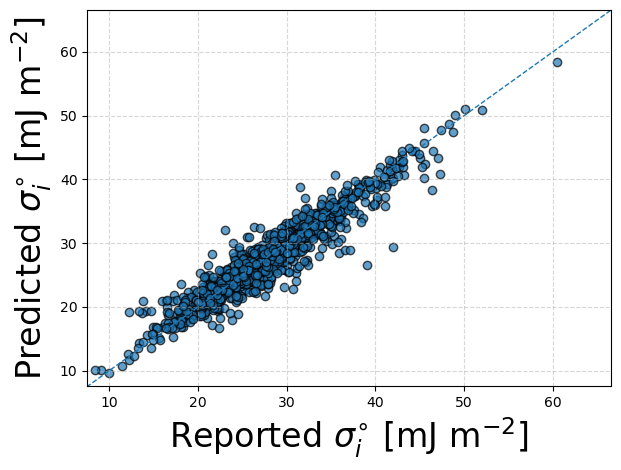

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:21] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [6]:
params = {'n_estimators': 4566, 
          'max_depth': 7,
          'min_child_weight': 6,
          'subsample': 0.987881314672957,
          'colsample_bytree': 0.8187129464368829,
          'eta': 0.01661912832701372, 
          'gamma': 0.149558867424321,
          'alpha': 1.1846139692358222e-05, 
          'lambda': 0.00011888751716855527,
          'random_state': 42,
          'monotone_constraints': (-1,) + (0,) * 10,
          'tree_method':'hist',
          'objective': 'reg:squarederror'
         }
model_gbm = XGBRegressor(**params)

model_gbm.fit(X_scaled,y)

preds_val = model_gbm.predict(X_scaled_val)
mse_val = mean_squared_error(y_val, preds_val)
r2_val = r2_score(y_val, preds_val)
print("MSE : ", mse_val)
print("R^2 : ", r2_val)
plt.scatter(y_val, preds_val, edgecolor='black', alpha=0.7)
plt.plot([0, 100], [0, 100], linestyle='--', linewidth=1)
plt.xlabel(r'Reported $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
plt.ylabel(r'Predicted $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(0.9*min(y_val), 1.1 * max(y_val))
plt.ylim(0.9*min(y_val), 1.1 * max(y_val))
plot_filename = f"./Figures/{datetime.now().strftime('%Y%m%d')}_XGBoost_Validation_Plot_Simp_Optuna.pdf"
#plt.savefig(plot_filename)
plt.show()
plt.close()
model_name = "XGBoost"
model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_XGBoost_Simp.json"
model_gbm.save_model(model_filename)
model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_XGBoost_Simp.bin"
model_gbm.save_model(model_filename)